# Part 3: Subset and download data using OGC Web Feature and Coverage Services (WFS/WCS)

The OWSLib library is a python library that makes accessing data and metadata through OGC services possible. The library abstracts all of the traditional HTTP API calls into programmatic function calls. We will be using this library throughout the tutorial to interact with the EMODnet OGC services.

The library is available from GitHub @  https://github.com/geopython/OWSLib

In [1]:
from owslib.wfs import WebFeatureService
from owslib.wcs import WebCoverageService
from owslib.wms import WebMapService
from owslib.etree import etree
import owslib.fes as fes 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import rasterio
import cartopy
import cartopy.crs as ccrs
import rioxarray
import geopandas as gpd
import warnings

## 3.1 Get vector data with WFS
#### Working with EMODnet Human Activities datasets

#### Create a WebFeatureService (WFS) object
Note that we use version 1.1.0 as in OWSLib this version has support for [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [2]:
wfs = WebFeatureService('https://ows.emodnet-humanactivities.eu/wfs', version = '1.1.0')

#### Find out what the WFS has to offer. Service metadata:

In [3]:
print(wfs.identification.type)
print(wfs.identification.version)
print(wfs.identification.title)
print(wfs.identification.abstract)

WFS
1.1.0
GeoServer Web Feature Service
This is the reference implementation of WFS 1.0.0 and WFS 1.1.0, supports all WFS operations including Transaction.


#### See available methods

In [4]:
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

#### Get available formats

In [5]:
wfs.getOperationByName('GetFeature').parameters

{'resultType': {'values': ['results', 'hits']},
 'outputFormat': {'values': ['text/xml; subtype=gml/3.1.1',
   'GML2',
   'KML',
   'SHAPE-ZIP',
   'application/gml+xml; version=3.2',
   'application/json',
   'application/vnd.google-earth.kml xml',
   'application/vnd.google-earth.kml+xml',
   'csv',
   'gml3',
   'gml32',
   'json',
   'text/csv',
   'text/xml; subtype=gml/2.1.2',
   'text/xml; subtype=gml/3.2']}}

#### Find out what vector datasets (FeatureTypes) are available
Note that only vector datasets that are uploaded trhough the Human Activities portal and are publicly available are shown

In [6]:
list(wfs.contents)

['emodnet:activelicenses',
 'emodnet:advisorycouncils',
 'emodnet:aquaculture',
 'emodnet:baltic',
 'emodnet:blacksea',
 'emodnet:longdistancefleet',
 'emodnet:market',
 'emodnet:mediterranean',
 'emodnet:northsea',
 'emodnet:northwesternwaters',
 'emodnet:outermostregions',
 'emodnet:pelagicstocks',
 'emodnet:southwesternwaters',
 'emodnet:aggregateareas',
 'emodnet:aggregates',
 'emodnet:fishingbeamtrawls',
 'emodnet:fishingbottomottertrawls',
 'emodnet:fishingbottomseines',
 'emodnet:fishingdredges',
 'emodnet:fishingpelagic',
 'emodnet:fishingstaticgears',
 'emodnet:fishingsubsurface',
 'emodnet:fishingsurface',
 'emodnet:barcelona',
 'emodnet:hydrocarbons',
 'emodnet:bucharest',
 'emodnet:desalination',
 'emodnet:dischargepoints',
 'emodnet:dredgespoil',
 'emodnet:dredgespoilpoly',
 'emodnet:dredging',
 'emodnet:munitions',
 'emodnet:munitionspoly',
 'emodnet:emeraldnetwork',
 'emodnet:faoareas_old',
 'emodnet:fao_areas',
 'emodnet:finfish',
 'emodnet:finfishV1',
 'emodnet:fishsal

#### Select the desired dataset among the list returned above

In [7]:
# Here we chose the European windfarms dataset presented as georeferenced polygons
dataset = 'emodnet:windfarmspoly'

#### Get the FeatureType Metadata an Bounding Box:

In [8]:
print(wfs.contents[dataset].title)
print(wfs.contents[dataset].abstract)
bbox1 = wfs.contents[dataset].boundingBoxWGS84
print (bbox1)

Wind Farms (Polygons)
The dataset on offshore wind farms in the European seas was created in 2014 by CETMAR for the European Marine Observation and Data Network (EMODnet). It is the result of the aggregation and harmonization of datasets provided by several sources. It is updated every year and it is available for viewing and download on EMODnet web portal (Human Activities, https://emodnet.ec.europa.eu/en/human-activities). The dataset contains points and/or (where available) polygons representing offshore wind farms in the following countries: Belgium, Denmark, Estonia, Finland, France, Germany, Greece, Ireland, Italy, Latvia, Lithuania, Netherlands, Norway, Poland, Portugal, Spain, Sweden and United Kingdom. Each point and polygon has the following attributes (where available): Name, Nº of turbines, Status (Approved, Planned, Dismantled, Construction, Production, Test site), Country, Year, Power (MW), Distance to coast (metres) and Area (square kilometres). The distance to coast (EE

#### Get the FeatureType’s schema via `DescribeFeatureType`.
The dictionary returned is compatible with a [Fiona schema object](https://fiona.readthedocs.io/en/latest/fiona.html#fiona.collection.Collection.schema).

In [9]:
wfs.get_schema(dataset)

{'properties': {'country': 'string',
  'n_turbines': 'int',
  'power_mw': 'decimal',
  'status': 'string',
  'year': 'string',
  'dist_coast': 'decimal',
  'area_sqkm': 'decimal',
  'notes': 'string'},
 'required': [],
 'geometry': 'GeometryCollection',
 'geometry_column': 'the_geom'}

#### Subset data with a bounding box

In [10]:
# Subset data with a bounding box
response = wfs.getfeature(typename=dataset,
                          bbox=(bbox1), #subset to the Study area ( based on bbox params)
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}.json')
gdf

,id,country,name,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,windfarmspoly.1,Sweden,Stora Middelgrund,108.0,864.0,Planned,NaN,24805.731113,59.826131,NaN,"MULTIPOLYGON (((12.03532 56.65295, 12.06134 56..."
1,windfarmspoly.2,Sweden,Lovstaviken,5.0,11.5,Production,NaN,0.000000,0.193854,NaN,"MULTIPOLYGON (((12.46710 56.89015, 12.47244 56..."
2,windfarmspoly.3,Sweden,Kattegatt Offshore,50.0,282.0,Approved,NaN,6381.649369,22.111037,NaN,"MULTIPOLYGON (((12.33361 56.86036, 12.34738 56..."
3,windfarmspoly.5,United Kingdom,Islay Demo Zone,10.0,10.0,Approved,NaN,1122.942248,27.611537,NaN,"MULTIPOLYGON (((-6.52572 55.65146, -6.55948 55..."
4,windfarmspoly.6,United Kingdom,North West Lewis (30MW),30.0,30.0,Planned,NaN,0.000000,51.062081,NaN,"MULTIPOLYGON (((-6.58016 58.36416, -6.58043 58..."
...,...,...,...,...,...,...,...,...,...,...,...
557,windfarmspoly.551,United Kingdom,Culzean,NaN,3.0,Planned,NaN,221021.383044,2.001045,NaN,"MULTIPOLYGON (((1.87627 57.19864, 1.87668 57.1..."
558,windfarmspoly.552,United Kingdom,Judy,NaN,15.0,Planned,NaN,259624.252434,8.045883,NaN,"MULTIPOLYGON (((2.27045 56.67040, 2.27103 56.6..."
559,windfarmspoly.568,United Kingdom,Offshore Wind Leasing Round 5 - PDA 1,NaN,0.0,Planned,NaN,35824.936586,369.050704,NaN,"MULTIPOLYGON (((-5.61768 51.23197, -5.61767 51..."
560,windfarmspoly.569,United Kingdom,Offshore Wind Leasing Round 5 - PDA 2,NaN,0.0,Planned,NaN,58291.392216,357.532494,NaN,"MULTIPOLYGON (((-5.61767 51.21310, -5.61767 51..."


### SETUP basemap

In [11]:
Bathy = WebMapService('https://ows.emodnet-bathymetry.eu/ows', version= '1.3.0')


In [12]:
[op.name for op in Bathy.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [13]:
Bathy.getOperationByName('GetMap').formatOptions

['image/png',
 'application/atom+xml',
 'application/json;type=utfgrid',
 'application/pdf',
 'application/rss+xml',
 'application/vnd.google-earth.kml+xml',
 'application/vnd.google-earth.kml+xml;mode=networklink',
 'application/vnd.google-earth.kmz',
 'image/geotiff',
 'image/geotiff8',
 'image/gif',
 'image/jpeg',
 'image/png; mode=8bit',
 'image/svg+xml',
 'image/tiff',
 'image/tiff8',
 'image/vnd.jpeg-png',
 'image/vnd.jpeg-png8',
 'text/html; subtype=openlayers',
 'text/html; subtype=openlayers2',
 'text/html; subtype=openlayers3']

## Get a coastlines basemap for plotting:

In [14]:
Bmap = Bathy['coastlines']
save_path = 'data/'
def getMap(filename, bbox, layerName):
    Bathy.getOperationByName('GetMap').formatOptions
    img = Bathy.getmap(layers= layerName,
                 size=(1200,600), 
                 srs='EPSG:4326',
                 bbox=bbox,
                 format='image/png',
                 style='contour',
                 transparent=True)

# Write the image to a temporary file
    out = open(os.path.join(save_path, filename), 'wb')
    out.write(img.read())
    out.close()  

# Define the layers to be used for the image, 
# here we use the multicolor bathymery dataset.
getMap(
    layerName=['coastlines'],
    bbox=(bbox1),
    filename = 'Basemap.png'
)
#read the image
image=mpimg.imread('data/Basemap.png')

c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\ogc_workshop\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


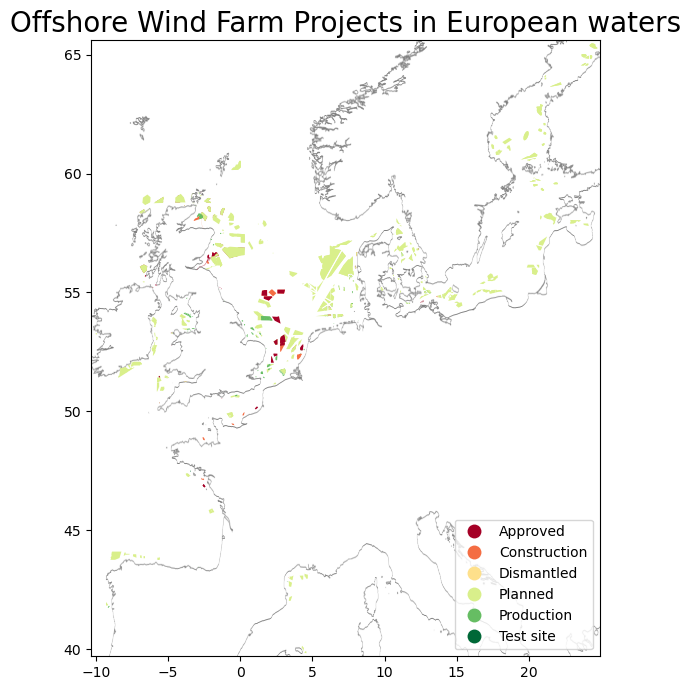

In [15]:
# Load the image representing the basemap
basemap_img = mpimg.imread('data/Basemap.png')

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(9, 8))

# Plot the basemap image using imshow
ax.imshow(basemap_img, extent=[bbox1[0],  bbox1[2], bbox1[1], bbox1[3]]) 

# Plot the data on top of the basemap
gdf.plot(column='status',                                       # Specify the column in which the data you need to plot is located
         categorical=False,
         cmap='RdYlGn',
         legend=True,
         legend_kwds={'loc': 'lower right'},
         alpha=1,
         ax=ax) 

# Set title and limits
ax.set_title('Offshore Wind Farm Projects in European waters', fontsize=20)
ax.set_xlim(bbox1[0], bbox1[2]) 
ax.set_ylim(bbox1[1], bbox1[3]) 

plt.show()

#### Subset data by attributes using [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [16]:
# Build a filter
sa_filter = fes.PropertyIsEqualTo(propertyname='status', literal='Planned') # Planned Windfarm projects
fid_filter = fes.PropertyIsBetween(propertyname='area_sqkm', lower = 1000, upper= 100000) # filter for projects bigger than 1000Km²
filter = fes.And([sa_filter,fid_filter]) # combine both filtering parameters using "AND"

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs.getfeature(typename=dataset,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}_filtered.json')
gdf

,id,country,name,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,windfarmspoly.286,United Kingdom,N3,NaN,0.0,Planned,2020,9457.333545,1106.354044,NaN,"MULTIPOLYGON (((-6.32441 59.05853, -6.31226 59..."
1,windfarmspoly.287,United Kingdom,N1,NaN,0.0,Planned,2020,3171.943570,1162.427300,NaN,"MULTIPOLYGON (((-4.10739 59.13575, -4.09759 59..."
2,windfarmspoly.289,United Kingdom,E2,NaN,0.0,Planned,2020,59706.165817,1291.429348,NaN,"MULTIPOLYGON (((-0.50129 57.47805, -0.48542 57..."
3,windfarmspoly.290,United Kingdom,E1,NaN,0.0,Planned,2020,56455.635331,3743.866036,NaN,"MULTIPOLYGON (((-0.47392 56.91518, -0.45823 56..."
4,windfarmspoly.440,Denmark,NaN,NaN,0.0,Planned,NaN,5000.551370,10079.276602,NaN,"MULTIPOLYGON (((14.60980 55.11517, 14.60971 55..."
5,windfarmspoly.40,Denmark,Nordsren II,NaN,0.0,Planned,NaN,49194.172947,1872.941410,NaN,"MULTIPOLYGON (((6.41926 55.80585, 6.41538 55.8..."
6,windfarmspoly.48,Denmark,Nordsren I,NaN,0.0,Planned,NaN,19964.419331,3176.148975,NaN,"MULTIPOLYGON (((7.79172 56.37805, 7.79165 56.3..."
7,windfarmspoly.36,Denmark,Nordsren III vest,NaN,0.0,Planned,NaN,109379.688310,4484.323143,NaN,"MULTIPOLYGON (((6.33084 56.44456, 6.32952 56.4..."
8,windfarmspoly.44,Denmark,Nordsren III,NaN,0.0,Planned,NaN,73863.316263,1642.587692,NaN,"MULTIPOLYGON (((6.51131 56.88091, 6.54150 56.8..."
9,windfarmspoly.81,Netherlands,IJmuiden Ver,NaN,4000.0,Planned,NaN,49466.898142,1172.060155,NaN,"MULTIPOLYGON (((3.74863 53.16913, 3.74864 53.0..."


## Change basemap to emodnet streetmap from bathy

c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\ogc_workshop\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


(39.712947845458984, 65.59857177734375)

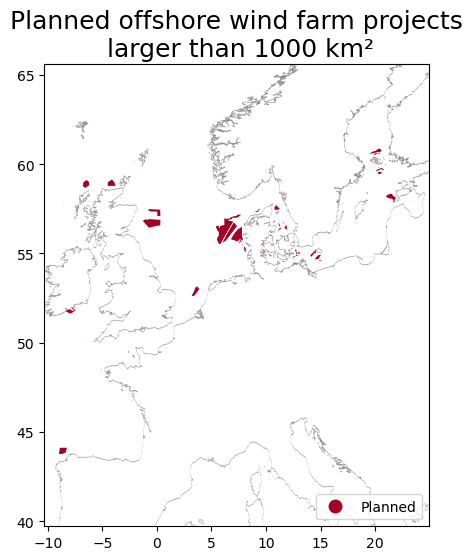

In [17]:
fig, ax = plt.subplots(1, figsize=(8,6))

# Plot the basemap image using imshow
ax.imshow(basemap_img, extent=[bbox1[0],  bbox1[2], bbox1[1], bbox1[3]])

#Plot the dataset
gdf.plot(column='status',
         categorical = False,
         cmap='RdYlGn',
         legend= True,
         legend_kwds={'loc': 'lower right'},
         alpha = 1,
         ax=ax)
ax.set_title('Planned offshore wind farm projects\n larger than 1000 km²',fontsize=18)

#Set the map limits based on the bbox params to zoom in on your dataset
ax.set_xlim(bbox1[0],bbox1[2]) 
ax.set_ylim(bbox1[1],bbox1[3])

## Example 2: Combining Subset of WFS request with a WCS (Web Coverage Services) request
### 1. Define a new study area

In this example, we will be looking to subset the _"Modelled occurrence probability for coralligenous habitats of the Mediterranean sea"_ dataset obtained from Seabed Habitats thematic of EMODnet, to the marine region of the Western Mediterranean sea (as defined by ICES Ecoregions).

#### 1.1 Connect to the MarineRegions.org WebFeatureService 
Marine Regions is an integration of the VLIMAR Gazetteer and the VLIZ Maritime Boundaries Geodatabase. The VLIMAR Gazetteer is a database with geographic, mainly marine names such as seas, sandbanks, seamounts, ridges, bays or even standard sampling stations used in marine research. It is accessible at: https://www.marineregions.org/gazetteer.php?p=search

In [18]:
wfs2 = WebFeatureService('https://geo.vliz.be/geoserver/MarineRegions/wfs', version= '1.1.0')

#Inspect available datasets
print(wfs2.identification.type)
print(wfs2.identification.version)
print(wfs2.identification.title)
print(wfs2.identification.abstract)
list(wfs2.contents)

WFS
1.1.0
Flanders Marine Institute (VLIZ) - WFS Service
This is the reference implementation of OGC WFS 1.0.0 and WFS 1.1.0, supports all WFS operations including Transaction.


['MarineRegions:eez_archipelagic_waters',
 'MarineRegions:arcticmarineareas',
 'MarineRegions:brasdorlakebiospherereserve',
 'MarineRegions:isa_ccz_managementarea',
 'MarineRegions:coasts_subnational',
 'MarineRegions:coasts_per_ocean',
 'MarineRegions:eez_24nm',
 'MarineRegions:comarge',
 'MarineRegions:cross_dateline_polygons',
 'MarineRegions:eca_reg13_nox',
 'MarineRegions:eca_reg14_sox_pm',
 'MarineRegions:eez',
 'MarineRegions:ecs',
 'MarineRegions:ecs_boundaries',
 'MarineRegions:fadaregions',
 'MarineRegions:fao',
 'MarineRegions:tnc_wwf_feow_hydrosheds',
 'MarineRegions:gsas_mediterraneanfishingzones',
 'MarineRegions:longhurst',
 'MarineRegions:goas',
 'MarineRegions:haedatgrids_polygon',
 'MarineRegions:high_seas',
 'MarineRegions:ices_ecoregions',
 'MarineRegions:ices_areas',
 'MarineRegions:ices_statistical_rectangles',
 'MarineRegions:iho',
 'MarineRegions:iho_quadrants_20150810',
 'MarineRegions:eez_internal_waters',
 'MarineRegions:itmarbiogeogsector_bianchi',
 'MarineR

In [19]:
#Define desired regional classification, here ICES Ecoregions
dataset2 = 'MarineRegions:ices_ecoregions'

# See available methods
[operation.name for operation in wfs2.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

In [20]:
#Inspect ICES Ecoregions dataset
print(wfs2.contents[dataset2].title)
print(wfs2.contents[dataset2].abstract)
bbox = wfs2.contents[dataset2].boundingBoxWGS84
print (bbox)

ICES Ecoregions (2015)
Delineation of the ICES Ecoregions was originally described in ICES Advice ACFM/ACE report(2004).

In the present updated version, the delineation has been updated to account for additional policy objectives and reconciling of legislation (eg the MSFD and the EU water and habitats directives)

The differences are based on the four principles:
1. Within the EU accept the MSFD regional and sub-regional definitions.
2. Separate Icelandic Seas from those around Greenland.
3. Use Large Marine Ecosystem units to define the Arctic Ocean.
4. Use the accepted Norwegian regional management plans definitions of the Norwegian and Barents Seas.

The Ecoregions were proposed to assist the implementation of the ecosystem approach in European waters
(-44.0000000000998, 30.2670495513959, 68.5000001347984, 90.0000000001001)


In [21]:
# Get the FeatureType’s schema via `DescribeFeatureType`
wfs2.get_schema(dataset2)

{'properties': {'objectid': 'int',
  'ecoregion': 'string',
  'mrgid': 'int',
  'longitude': 'decimal',
  'latitude': 'decimal',
  'area_km2': 'decimal',
  'placetype': 'string',
  'placetypei': 'int',
  'parent': 'string',
  'parentid': 'int',
  'source': 'string',
  'sourceid': 'int',
  'lon_min': 'decimal',
  'lon_max': 'decimal',
  'lat_min': 'decimal',
  'lat_max': 'decimal'},
 'required': [],
 'geometry': 'MultiPolygon',
 'geometry_column': 'the_geom'}

#### 1.2 Inspect the ICES Ecoregions datasets
Listing all available regional delimitations based on the ICES Ecoregions classification

In [22]:
response = wfs2.getfeature(typename=dataset2,
                          bbox=(bbox), 
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'data/{dataset2.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
import geopandas as gpd
gdf = gpd.read_file(f'data/{dataset2.replace(":","_")}.json')
gdf

,id,objectid,ecoregion,mrgid,longitude,latitude,area_km2,placetype,placetypei,parent,parentid,source,sourceid,lon_min,lon_max,lat_min,lat_max,geometry
0,ices_ecoregions.1,1,Greenland Sea,36310,-28.070627,69.670326,1.065385e+06,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-44.000000,5.677908,56.560460,82.304253,"MULTIPOLYGON (((-43.99177 60.29694, -44.00000 ..."
1,ices_ecoregions.2,2,Bay of Biscay and the Iberian Coast,36311,-8.886815,42.662908,7.557796e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-13.861560,-0.146245,36.000000,48.000002,"MULTIPOLYGON (((-5.60000 36.01104, -5.60000 36..."
2,ices_ecoregions.3,3,Azores,36312,-28.438624,39.154203,7.928794e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-35.579300,-20.855320,36.000000,43.067630,"MULTIPOLYGON (((-21.05878 36.00000, -23.49448 ..."
3,ices_ecoregions.4,4,Western Mediterranean Sea,22167,6.109270,39.531134,8.444074e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-5.600000,16.223122,35.070668,44.427203,"MULTIPOLYGON (((2.99963 43.14220, 2.99973 43.1..."
4,ices_ecoregions.5,5,Ionian Sea and the Central Mediterranean Sea,36313,17.320194,35.190387,7.726428e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,10.015849,24.122811,30.267050,40.520659,"MULTIPOLYGON (((24.12281 34.80180, 24.12272 34..."
5,ices_ecoregions.6,6,Black Sea,22172,34.262870,43.464598,4.747685e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,26.175552,42.354960,39.998909,47.376395,"MULTIPOLYGON (((41.58356 42.40528, 41.57035 42..."
6,ices_ecoregions.7,7,Adriatic Sea,36314,16.118553,42.714787,1.392988e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,12.065226,20.020828,39.744192,45.808914,"MULTIPOLYGON (((19.99367 39.79384, 19.99293 39..."
7,ices_ecoregions.8,8,Aegean-Levantine Sea,22169,28.686066,34.822184,7.567145e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,22.149885,36.215729,30.756594,41.091326,"MULTIPOLYGON (((25.74529 36.79303, 25.74350 36..."
8,ices_ecoregions.9,9,Celtic Seas,22173,-9.264609,54.591504,9.177512e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-16.090850,1.806284,48.000002,63.890844,"MULTIPOLYGON (((1.37123 62.00000, 1.37123 62.0..."
9,ices_ecoregions.10,10,Baltic Sea,22170,19.497017,58.713587,3.999565e+05,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,9.419914,31.685704,52.871122,67.080588,"MULTIPOLYGON (((11.07890 53.14186, 11.09182 53..."


#### 1.3 Write a filter to select the desired region (Greater North Sea)

,id,objectid,ecoregion,mrgid,longitude,latitude,area_km2,placetype,placetypei,parent,parentid,source,sourceid,lon_min,lon_max,lat_min,lat_max,geometry
0,ices_ecoregions.4,4,Western Mediterranean Sea,22167,6.10927,39.531134,844407.444602,ICES Ecoregion,246,ICES Ecoregions,22540,ICES,378,-5.6,16.223122,35.070668,44.427203,"MULTIPOLYGON (((2.99963 43.14220, 2.99973 43.1..."


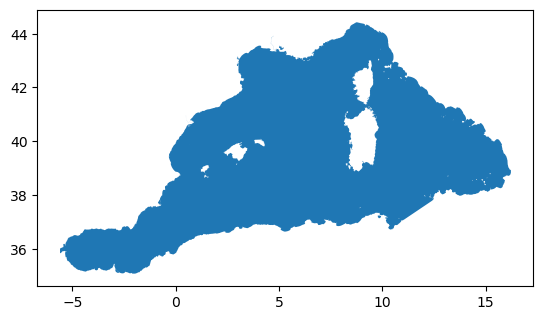

In [23]:
# Build a filter
filter = fes.PropertyIsEqualTo(propertyname='ecoregion', literal='Western Mediterranean Sea') # Specifying the needed Ecoregion

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs2.getfeature(typename = dataset2,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{dataset2.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
Study_area = gpd.read_file(f'data/{dataset2.replace(":","_")}_filtered.json')

# Plot and inspect the study area dataset
Study_area.plot()
Study_area

### 3.2 Get raster data with WCS connecting to the Seabed Habitats Thematic of EMODnet

#### <i>Create a WebCoverageService (WCS) object</i>

In [24]:
wcs = WebCoverageService('https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open_maplibrary/wcs', version = '2.0.1')

#### <i>Get a list of available coverages</i>

In [25]:
for coverage_name in wcs.contents.keys():
    print(coverage_name)

emodnet_open_maplibrary__Corine_2018_Coastal_Wetlands_WGS84
emodnet_open_maplibrary__Modiolus_habitatsuitabilitymodel_uk_50
emodnet_open_maplibrary__Sabellaria_habitatsuitabilitymodel_uk_50
emodnet_open_maplibrary__Zostera_habitatsuitabilitymodel_uk_50
emodnet_open_maplibrary__LAMpred_Nordic
emodnet_open_maplibrary__SACpred_Nordic
emodnet_open_maplibrary__mediseh_cora
emodnet_open_maplibrary__mediseh_maerl
emodnet_open_maplibrary__mediseh_posidonia
emodnet_open_maplibrary__DK004008_EFH_Cod_Spawning grounds
emodnet_open_maplibrary__DK004009_EFH_Cod_Feeding grounds
emodnet_open_maplibrary__DK004010_EFH_Cod_Nursery grounds
emodnet_open_maplibrary__DK004011_EFH_Plaice_Spawning grounds
emodnet_open_maplibrary__DK004012_EFH_Plaice_Feeding grounds
emodnet_open_maplibrary__DK004013_EFH_Plaice_Nursery grounds
emodnet_open_maplibrary__DK004014_EFH_Sole_Feeding grounds
emodnet_open_maplibrary__DK004015_EFH_Sole_Nursery grounds
emodnet_open_maplibrary__DK004016_EFH_Turbot_Feeding grounds
emodnet_o

#### <i>Define the dataset</i>
Here we select the "modelled occurrence probability for coralligenous habitats of the Mediterranean sea" dataset

In [26]:
dataset = 'emodnet_open_maplibrary__mediseh_cora'

#### <i>Retrieve a list of available properties of a coverage</i>

In [27]:
for item in dir(wcs.contents[dataset]):
    if "_" not in item:
        print(item)
        

abstract
axisDescriptions
boundingBox
boundingBoxWGS84
boundingboxes
crsOptions
defaulttimeposition
grid
id
keywords
styles
supportedCRS
supportedFormats
timelimits
timepositions
title


#### <i>Retrieve grid property information</i>

In [28]:
for item in dir(wcs.contents[dataset].grid):
    if "_" not in item:
        print(item + ": " + str(wcs.contents[dataset].grid.__dict__[item]))

axislabels: ['i', 'j']
dimension: 2
highlimits: ['13781', '6398']
lowlimits: ['0', '0']
offsetvectors: [['400.0', '0.0'], ['0.0', '-400.0']]
origin: ['-729757.059693927', '5991106.766843']


#### Get geo-bounding boxes and native CRS

In [29]:
print(wcs.contents[dataset].boundingboxes)
print(wcs.contents[dataset].supportedCRS)
print(wcs.contents[dataset].supportedFormats)
print(wcs.contents[dataset].boundingBox)
print(wcs.contents[dataset].boundingBoxWGS84)

[{'nativeSrs': 'http://www.opengis.net/def/crs/EPSG/0/3857', 'bbox': (-729957.059693927, 3431706.7668430004, 4782842.940306073, 5991306.766843)}]
[]
['application/gml+xml', 'image/jpeg', 'image/png', 'image/tiff', 'image/tiff;application=geotiff', 'text/plain']
None
None


This output shows us that the native CRS of the dataset we are accessing is EPSG 3857 and there are no other supported CRS ('print(wcs.contents[dataset].supportedCRS)')

#### Retrieve supported formats

In [30]:
wcs.contents[dataset].supportedFormats

['application/gml+xml',
 'image/jpeg',
 'image/png',
 'image/tiff',
 'image/tiff;application=geotiff',
 'text/plain']

### Inspect then subset and download raster data using a GetCoverage request

In [31]:
# get parameters for grid
bbox2 = Study_area.bounds.values[0].tolist() # get bbox for the Western Mediterranean Sea study area 
crs2 = Study_area.crs.srs # get crs of the Study Area file

In [32]:
#Adding 2 decimal degrees to each side of the bbox

bbox2 = [bbox2[0]-2,bbox2[1]-2,bbox2[2]+2,bbox2[3]+2]
print(bbox2)

[-7.6, 33.07066846, 18.22312212, 46.42720294]


In [33]:
# GetCoverage request
response = wcs.getCoverage(identifier=[dataset],
                           bbox=bbox2,
                           format='image/tiff',
                           crs=crs2,
                           resx=0.00833333,resy=0.00833333,
                           timeout = 120
                           )
print(response.geturl())
with open(f'data/{dataset.replace(":","_")}.tif','wb') as outfile:
    outfile.write(response.read())


https://ows.emodnet-seabedhabitats.eu/geoserver/emodnet_open_maplibrary/wcs?version=2.0.1&request=GetCoverage&service=WCS&CoverageID=emodnet_open_maplibrary__mediseh_cora&crs=EPSG%3A4326&format=image%2Ftiff


### Inspect then Clip the raster dataset to the study area using rasterio

#### Compare the Study area and Raster CRS and Bounding boxes:

In [34]:
# Open the raster file
with rasterio.open(f'data/{dataset.replace(":", "_")}.tif') as src:
    raster_crs = src.crs  # Get raster CRS

print(f"Raster CRS: {raster_crs}")
print(f"Study Area CRS: {crs2}")
print(f"Raster Bbox: {bbox}")
print(f"Study Area Bbox: {bbox2}")

if raster_crs != crs2:
    print("Need to reproject raster to match raster CRS.")

Raster CRS: EPSG:3857
Study Area CRS: EPSG:4326
Raster Bbox: (-44.0000000000998, 30.2670495513959, 68.5000001347984, 90.0000000001001)
Study Area Bbox: [-7.6, 33.07066846, 18.22312212, 46.42720294]
Need to reproject raster to match raster CRS.


#### Reproject the Raster data to match the Study Area CRS:

In [39]:
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define input and output file paths
input_raster = f'data/{dataset.replace(":", "_")}.tif'
output_raster = f'data/{dataset.replace(":", "_")}_reprojected.tif'

# Open the original raster
with rasterio.open(input_raster) as src:
    # Define target CRS (Study Area CRS)
    dst_crs = "EPSG:4326"

    # Calculate new transform, width, and height
    transform, width, height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )

    # Update metadata for the new raster
    kwargs = src.meta.copy()
    kwargs.update({
        'crs': dst_crs,
        'transform': transform,
        'width': width,
        'height': height
    })

    # Perform the reprojection
    with rasterio.open(output_raster, 'w', **kwargs) as dst:
        for i in range(1, src.count + 1):  # Loop through raster bands
            reproject(
                source=rasterio.band(src, i),
                destination=rasterio.band(dst, i),
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=transform,
                dst_crs=dst_crs,
                resampling=Resampling.nearest
            )

print(f"Reprojected raster saved at: {output_raster}")

Reprojected raster saved at: data/emodnet_open_maplibrary__mediseh_cora_reprojected.tif


#### Clip the reprojected raster data to match the study area

In [40]:
with rasterio.open(f'data/{dataset.replace(":","_")}_reprojected.tif') as src:
    # Clip the raster using the study area geometry
    out_image, out_transform = rasterio.mask.mask(src, Study_area.geometry, crop=True)
    out_meta = src.meta
    print(out_meta)

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Create a new raster file containing the clipped data
clipped_raster_path = f'data/{dataset.replace(":","_")}_clipped.tif'

with rasterio.open(clipped_raster_path, "w", **out_meta) as dest:
    dest.write(out_image)


{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -3.4028234663852886e+38, 'width': 14294, 'height': 5155, 'count': 1, 'crs': CRS.from_epsg(4326), 'transform': Affine(0.0034645994105386834, 0.0, -6.557315834740004,
       0.0, -0.0034645994105386834, 47.300772718499964)}


#### Open the clipped rasterdata in an xarray object using the rasterio library

In [37]:
rasterdata_clipped = rioxarray.open_rasterio(f'data/{dataset.replace(":","_")}_clipped.tif')
rasterdata_clipped

<xarray.DataArray (band: 1, y: 2702, x: 6300)>
[17022600 values with dtype=float32]
Coordinates:
  * band         (band) int32 1
  * x            (x) float64 -5.599 -5.596 -5.592 -5.589 ... 16.22 16.22 16.22
  * y            (y) float64 44.43 44.42 44.42 44.42 ... 35.08 35.08 35.07 35.07
    spatial_ref  int32 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     -3.4028235e+38
    scale_factor:   1.0
    add_offset:     0.0

#### Plot a map of the clipped rasterdata overlaid with the study area

This time we will use Cartopy features to plot the basemap.

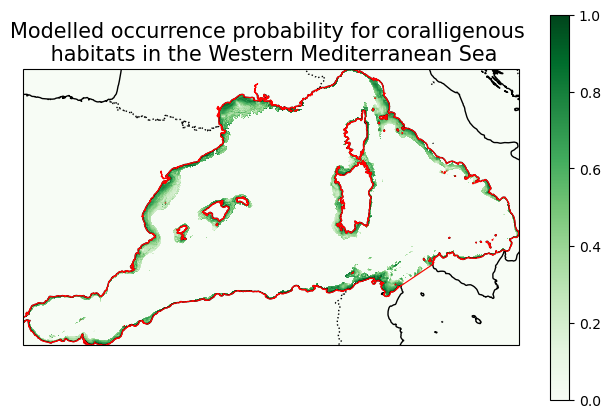

In [41]:
warnings.simplefilter("ignore", RuntimeWarning)

fig = plt.figure(figsize=(8,10))# Increase the figure size
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())

#add Basemap features from Cartopy
ax.add_feature(cartopy.feature.OCEAN, )
ax.add_feature(cartopy.feature.LAND)
ax.add_feature(cartopy.feature.BORDERS, linestyle=':')
ax.coastlines(resolution='10m')

#plot the data
cbar_kwargs = {'shrink':0.5, 'extend': 'neither'}                                                             
rasterdata_clipped.plot(ax=ax, cmap = 'Greens', vmin = 0 , vmax = 1, cbar_kwargs = cbar_kwargs) # plot raster data
Study_area.boundary.plot(ax=ax, color=None, edgecolor = 'red',linewidth=0.8 , label = 'Study Area')

ax.set_title('Modelled occurrence probability for coralligenous \n habitats in the Western Mediterranean Sea', fontsize=15)

# Close the raster file after plotting
rasterdata_clipped.close()

### [>> Next: Tutorial Part 4: Web Map Tiling Services and interactive maps](Tutorial_Part_4_WMTS.ipynb)

<hr>

<a href="https://emodnet.ec.europa.eu/"><img style="float:left;border-width:0;width:200px" src="https://emodnet.ec.europa.eu/sites/emodnet.ec.europa.eu/files/public/emodnet_logos/web/EMODnet_standard_colour.png" /></a><a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>